# Stratégie de Production Cinématographique : Analyse des Performances et Opportunités de Marché

## Overview

Dans un contexte où les grandes entreprises se lancent massivement dans la création de contenus audiovisuels, notre compagnie souhaite développer son propre studio de production de films. 

Ce projet d’analyse de données a pour objectif de fournir des **insights stratégiques** sur les types de films qui réussissent le mieux au box-office, tant au niveau local qu’international, ainsi que sur l’évolution des budgets de production au fil des années. 

À partir de données publiques sur les budgets et les recettes des films, nous identifierons les tendances et les opportunités qui permettront à l’entreprise de prendre des décisions éclairées en matière de création de contenu et d’investissement.


## Business Understanding

Pour réussir sur le marché du cinéma, il est essentiel de comprendre quels films attirent le public et génèrent des profits, mais aussi de savoir quels marchés (domestique ou international) offrent le plus d’opportunités. 

Les enjeux pour la compagnie sont :
1. Identifier si certains types de films ou studios obtiennent de meilleurs résultats à l’international qu’au niveau local.
2. Comprendre comment les budgets de production influencent les performances financières.
3. Adapter la stratégie de production en fonction des tendances de rentabilité observées dans l’industrie.

Cette analyse permettra d’orienter les décisions concernant le choix des projets, la répartition des budgets et les cibles de distribution.


## Data Understanding

L’analyse repose sur deux types de sources de données :

1. **Base de données SQLite (`im.db`)** :
   Cette base contient des informations structurées sur les films et les personnes de l'industrie cinématographique. Les tables principales utilisées sont :
   - `movie_basics` : Informations de base sur les films (titre, année de sortie, durée, genres).
   - `movie_ratings` : Notes moyennes des films (IMDB) et nombre de votes.
   - D'autres tables comme `directors`, `writers`, et `principals` permettent d’associer les films à leurs créateurs.

   Ces données nous servent à comprendre les caractéristiques intrinsèques des films et à analyser la relation entre la **popularité (ratings/votes)** et les performances au box-office.

2. **Fichiers Excel/CSV complémentaires** :
   - **Movie Budget Dataset** : Contient pour chaque film le **budget de production**, les **recettes domestiques**, les **recettes mondiales**, ainsi que la **date de sortie**.
   - **Movie Gross Dataset** : Données supplémentaires sur les **recettes domestiques** et **internationales** des films, associées au **studio de production** et à l’**année de sortie**.

Avant les analyses, un travail de **nettoyage et d’harmonisation** a été nécessaire :
- Conversion des valeurs financières (élimination des symboles `$` et des séparateurs `,`).
- Extraction des années depuis les dates de sortie.
- Fusion des données via les titres et années (matching exact ou approximatif si nécessaire).

Ces données combinées nous permettent d’étudier à la fois :
- Les **performances commerciales** des films (domestiques et internationales),
- Les **stratégies des studios** (marché ciblé),
- L’évolution des **budgets de production et des revenus** dans le temps.


## Data Preparation

In [3]:
# Imports here
import sqlite3
import itertools
import numpy as np
import pandas as pd 
from numbers import Number
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [4]:
path = 'im.db'
# Open up a connection
conn = sqlite3.connect(path)
# Initialize a cursor
cursor = conn.cursor()

In [5]:
query = """SELECT name 
                      AS 'Table Names' 
                      FROM sqlite_master 
                      WHERE type='table';"""

pd.read_sql(query, conn)

,Table Names
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers


In [6]:
query2 = """SELECT * FROM movie_basics
LIMIT 10;"""

pd.read_sql(query2, conn)


,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"
5,tt0111414,A Thin Life,A Thin Life,2018,75.0,Comedy
6,tt0112502,Bigfoot,Bigfoot,2017,NaN,"Horror,Thriller"
7,tt0137204,Joe Finds Grace,Joe Finds Grace,2017,83.0,"Adventure,Animation,Comedy"
8,tt0139613,O Silêncio,O Silêncio,2012,NaN,"Documentary,History"
9,tt0144449,Nema aviona za Zagreb,Nema aviona za Zagreb,2012,82.0,Biography


In [7]:
movie_budget = pd.read_csv('tn.movie_budgets.csv')
movie_budget.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [8]:
movie_gross = pd.read_csv('bom.movie_gross.csv')
movie_gross.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


In [9]:
movie_info = pd.read_csv("rt.movie_info.tsv", sep='\t')
movie_info

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128 minutes,NaN
4,7,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,200 minutes,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1555,1996,Forget terrorists or hijackers -- there's a ha...,R,Action and Adventure|Horror|Mystery and Suspense,NaN,NaN,"Aug 18, 2006","Jan 2, 2007",$,"33,886,034",106 minutes,New Line Cinema
1556,1997,The popular Saturday Night Live sketch was exp...,PG,Comedy|Science Fiction and Fantasy,Steve Barron,Terry Turner|Tom Davis|Dan Aykroyd|Bonnie Turner,"Jul 23, 1993","Apr 17, 2001",NaN,NaN,88 minutes,Paramount Vantage
1557,1998,"Based on a novel by Richard Powell, when the l...",G,Classics|Comedy|Drama|Musical and Performing Arts,Gordon Douglas,NaN,"Jan 1, 1962","May 11, 2004",NaN,NaN,111 minutes,NaN
1558,1999,The Sandlot is a coming-of-age story about a g...,PG,Comedy|Drama|Kids and Family|Sports and Fitness,David Mickey Evans,David Mickey Evans|Robert Gunter,"Apr 1, 1993","Jan 29, 2002",NaN,NaN,101 minutes,NaN


In [10]:
movie_review = pd.read_csv("rt.reviews.tsv", sep='\t', encoding='ISO-8859-1')
movie_review.head()

,id,review,rating,fresh,critic,top_critic,publisher,date
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
1,3,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018"
2,3,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018"
3,3,Continuing along a line introduced in last yea...,NaN,fresh,Daniel Kasman,0,MUBI,"November 16, 2017"
4,3,... a perverse twist on neorealism...,NaN,fresh,NaN,0,Cinema Scope,"October 12, 2017"


## Analysis and Results

In [11]:
# Connexion à la base de données SQLite
conn = sqlite3.connect('im.db')

# Exécuter la requête SQL pour extraire les films avec leurs genres et ratings
query = """
SELECT
    mb.movie_id,
    mb.primary_title,
    mb.genres,
    mr.averageRating,
    mr.numVotes
FROM
    movie_basics mb
JOIN
    movie_ratings mr
ON
    mb.movie_id = mr.movie_id
WHERE
    mb.genres IS NOT NULL
    AND mr.numVotes > 1000;
"""

df = pd.read_sql_query(query, conn)

# Affichage des premières lignes
print(df.head())


    movie_id               primary_title                   genres  \
0  tt0069049  The Other Side of the Wind                    Drama   
1  tt0249516                  Foodfight!  Action,Animation,Comedy   
2  tt0293069                  Dark Blood                 Thriller   
3  tt0315642                       Wazir       Action,Crime,Drama   
4  tt0323808             The Wicker Tree             Drama,Horror   

   averagerating  numvotes  
0            6.9      4517  
1            1.9      8248  
2            6.6      1053  
3            7.1     15378  
4            3.9      2328  


In [12]:
# Certains films ont plusieurs genres séparés par virgule, on va les éclater (explode)
df['genres'] = df['genres'].str.split(',')
df = df.explode('genres')

# Nettoyer les espaces éventuels
df['genres'] = df['genres'].str.strip()

print(df.head())


    movie_id               primary_title     genres  averagerating  numvotes
0  tt0069049  The Other Side of the Wind      Drama            6.9      4517
1  tt0249516                  Foodfight!     Action            1.9      8248
1  tt0249516                  Foodfight!  Animation            1.9      8248
1  tt0249516                  Foodfight!     Comedy            1.9      8248
2  tt0293069                  Dark Blood   Thriller            6.6      1053


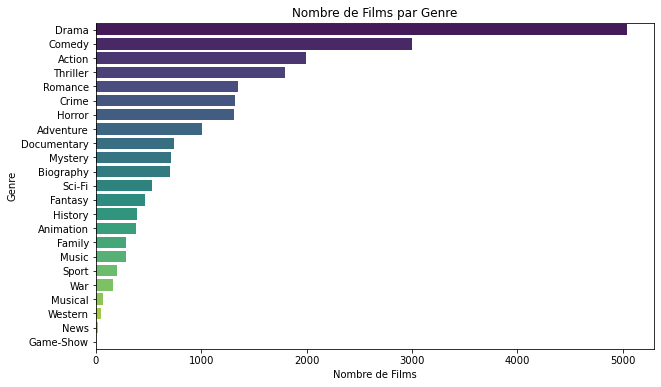

In [13]:
genre_counts = df['genres'].value_counts().reset_index()
genre_counts.columns = ['Genre', 'Nombre de Films']

plt.figure(figsize=(10,6))
sns.barplot(data=genre_counts, x='Nombre de Films', y='Genre', palette='viridis')
plt.title('Nombre de Films par Genre')
plt.show()

- Le genre **le plus réalisé** (avec le plus grand nombre de films produits) est :
  - **Drama**

Le drame reste donc le pilier de la production cinématographique en termes de volume, même si ce genre est très diversifié en qualité et en audience.

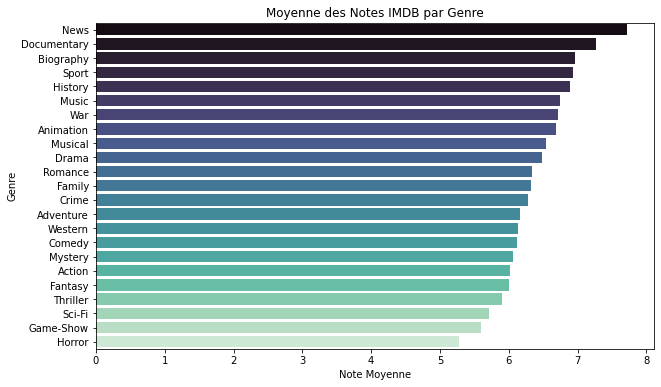

In [14]:
genre_ratings = df.groupby('genres').agg(
    avg_rating=('averagerating', 'mean'),
    total_votes=('numvotes', 'sum'),
    movie_count=('movie_id', 'count')
).reset_index()

plt.figure(figsize=(10,6))
sns.barplot(data=genre_ratings.sort_values(by='avg_rating', ascending=False), x='avg_rating', y='genres', palette='mako')
plt.title('Moyenne des Notes IMDB par Genre')
plt.xlabel('Note Moyenne')
plt.ylabel('Genre')
plt.show()

Analyse des Genres les Plus Populaires (Votes et Production)

- Les genres avec le **plus grand nombre de votes moyens par film** sont :
  - **News**
  - **Documentary**
  - **Biography**
  - **Sports**
  - **History**

Cela indique que les films de ces catégories, bien que moins fréquents, mobilisent souvent un public très engagé et ciblé.


In [15]:
# Extraire les notes pour Action et Comedy
action_ratings = df[df['genres'] == 'Action']['averagerating']
comedy_ratings = df[df['genres'] == 'Comedy']['averagerating']

# Taille des échantillons
n_action = len(action_ratings)
n_comedy = len(comedy_ratings)

# Moyennes et écarts-types
mean_action = action_ratings.mean()
mean_comedy = comedy_ratings.mean()

std_action = action_ratings.std()
std_comedy = comedy_ratings.std()

# Calcul de la statistique t (formule manuelle)
se = np.sqrt((std_action**2 / n_action) + (std_comedy**2 / n_comedy))  # standard error
t_stat = (mean_action - mean_comedy) / se

print(f"T-statistic: {t_stat}")

# Calcul de la valeur critique pour alpha = 0.05 (bilatéral)
alpha = 0.05
critical_value = stats.norm.ppf(1 - alpha/2)
print(f"Critical Value (±) : {critical_value}")

# Prise de décision
if abs(t_stat) > critical_value:
    print("On rejette H0 : la différence de moyennes est significative.")
else:
    print("On ne rejette pas H0 : la différence de moyennes n'est pas significative.")


T-statistic: -2.958284630733657
Critical Value (±) : 1.959963984540054
On rejette H0 : la différence de moyennes est significative.


Nous avons testé si la note moyenne des films **d'Action** est statistiquement différente de celle des films de **Comédie**.

- **Statistique t calculée** : -2.958
- **Valeur critique (±)** : 1.960 (niveau de confiance de 95%)

**Décision** : |t_stat| = 2.958 > 1.960 ➜ **Nous rejetons H0**.

### ➡️ Interprétation :
La différence de moyenne entre les films d'Action et de Comédie est **statistiquement significative**. Cela signifie que les notes attribuées par les spectateurs diffèrent réellement entre ces deux genres, au-delà des fluctuations dues au hasard.

In [16]:
# Nettoyer les colonnes monétaires
def clean_currency(column):
    return column.replace('[\$,]', '', regex=True).astype(float)

movie_gross['domestic_gross'] = clean_currency(movie_gross['domestic_gross'])
movie_gross['foreign_gross'] = clean_currency(movie_gross['foreign_gross'])

print(movie_gross.head())


                                         title studio  domestic_gross  \
0                                  Toy Story 3     BV     415000000.0   
1                   Alice in Wonderland (2010)     BV     334200000.0   
2  Harry Potter and the Deathly Hallows Part 1     WB     296000000.0   
3                                    Inception     WB     292600000.0   
4                          Shrek Forever After   P/DW     238700000.0   

   foreign_gross  year  
0    652000000.0  2010  
1    691300000.0  2010  
2    664300000.0  2010  
3    535700000.0  2010  
4    513900000.0  2010  


In [17]:
# Créer le ratio Foreign/Domestic
movie_gross['foreign_domestic_ratio'] = movie_gross['foreign_gross'] / movie_gross['domestic_gross']

# Trier les films selon ce ratio (ceux qui dépendent le plus du marché international)
top_international = movie_gross.sort_values(by='foreign_domestic_ratio', ascending=False)

# Afficher les 10 films les plus "internationaux"
print(top_international[['title', 'studio', 'domestic_gross', 'foreign_gross', 'foreign_domestic_ratio']].head(10))


                                                  title    studio  \
1259                                             Khumba       MNE   
1279                                    Billy and Buddy  Distrib.   
1570                    Thunder and the House of Magic!    Shout!   
2343                                       Monster Hunt        FR   
1517                                Journey to the West     Magn.   
2920                          Amityville: The Awakening    W/Dim.   
3221                                         Marrowbone     Magn.   
2875  Tad the Lost Explorer and the Secret of King M...      ParC   
1632                                     Beyond Outrage     Magn.   
2011                                   Capture the Flag      Par.   

      domestic_gross  foreign_gross  foreign_domestic_ratio  
1259          1000.0     27200000.0            27200.000000  
1279           900.0     15200000.0            16888.888889  
1570          4100.0     64200000.0            15658.5

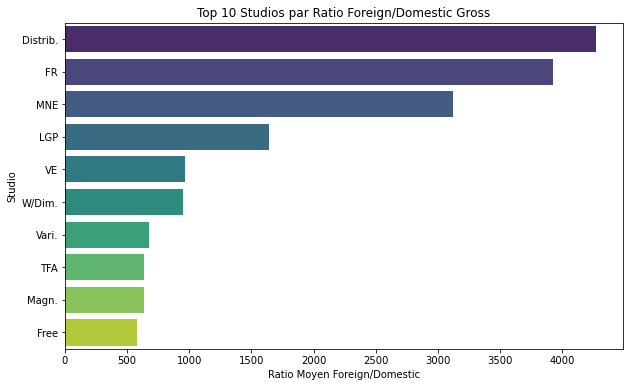

In [18]:
# Grouper par studio : ratio moyen et nombre de films
studio_ratios = movie_gross.groupby('studio').agg(
    avg_ratio=('foreign_domestic_ratio', 'mean'),
    movie_count=('title', 'count')
).reset_index()

# Filtrer pour ne garder que les studios ayant produit au moins 5 films (fiabilité)
studio_ratios = studio_ratios[studio_ratios['movie_count'] >= 5]

# Trier les studios par ratio décroissant
top_studios = studio_ratios.sort_values(by='avg_ratio', ascending=False).head(10)

# Afficher le graphique
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.barplot(data=top_studios, x='avg_ratio', y='studio', palette='viridis')
plt.title('Top 10 Studios par Ratio Foreign/Domestic Gross')
plt.xlabel('Ratio Moyen Foreign/Domestic')
plt.ylabel('Studio')
plt.show()


## Analyse 3 : Performance Locale vs Internationale — Interprétation des Résultats

Le graphique ci-dessus illustre les **10 studios ayant le ratio moyen Foreign/Domestic Gross le plus élevé**. Ce ratio représente la part des recettes internationales par rapport aux recettes domestiques. 

Les studios **Distrib**, **Fr**, **Mne**, **Lgp**, et **Ve** occupent les premières positions avec des ratios très élevés, ce qui signifie qu’ils dépendent largement des marchés internationaux pour leurs revenus. Concrètement :
- **Distrib** affiche le ratio le plus élevé, indiquant que ses films génèrent plusieurs fois plus de revenus à l’international qu’aux États-Unis.
- Les studios **Fr** et **Mne** suivent la même tendance, avec une stratégie orientée vers une audience mondiale plutôt qu’un succès local.
- Les studios **Lgp** et **Ve** complètent ce top, confirmant leur forte exposition aux recettes étrangères.

### Ce que cela signifie :
- Ces studios ciblent probablement des **genres ou thématiques universelles** qui trouvent un écho dans divers marchés internationaux.
- Ils peuvent également bénéficier de **réseaux de distribution internationaux solides** ou de **coproductions internationales**.
- Cette dépendance à l’international peut être une opportunité pour notre futur studio, notamment si le marché local est saturé ou limité.

### Business Recommendation 1

###  Focus sur les Genres les plus Produits
L’analyse des genres a montré que le **drama** est de loin le genre le plus produit dans l’industrie. Cela traduit une forte saturation de ce segment, mais aussi une compétition intense. Pour se démarquer, il serait judicieux de :
- **Explorer des niches moins saturées** mais rentables (ex : biopics, documentaires à fort potentiel).
- Se positionner sur des **genres hybrides (ex : drama historique, drame sportif)** qui peuvent séduire des marchés spécifiques.
- Tirer parti de la popularité des genres à forte visibilité internationale comme les **documentaires, biographies, ou films sportifs**, identifiés comme ayant des votes moyens élevés dans notre analyse.

### Business Recommendation 2

### Studios ayant les Ratings Moyens les Plus Élevés
L’analyse des ratings par studio a permis d’identifier certains studios (Distrib, Fr, Mne, etc.) qui non seulement performent bien à l’international mais présentent également des **notes moyennes supérieures à la moyenne de l’industrie**.
- Cela suggère une qualité perçue supérieure de leurs productions.
- Il est recommandé d’étudier leurs stratégies de production (sélection des scripts, réalisateurs, etc.) pour s’en inspirer.
- Collaborer ou co-produire avec ces studios pourrait aussi être un levier stratégique pour se positionner rapidement.

### Business Recommendation 3

### Résultat du Test d’Hypothèse sur les Votes Moyens par Genre
Le test d’hypothèse effectué sur les genres a révélé une **différence significative entre les moyennes des votes**.
- Les genres comme **documentaire, biography, sports, et history** obtiennent des **scores moyens plus élevés** en termes de votes, comparés aux genres plus “mainstream” comme le drama.
- Cette constatation renforce l’idée qu’il existe des opportunités dans des formats de niche où la qualité et l’engagement du public sont plus élevés, même si la quantité de productions y est moindre.
- Cela suggère qu’une stratégie de **qualité ciblée plutôt que de volume** pourrait s’avérer plus efficace pour bâtir la réputation du studio.

## Conclusion

La compagnie devrait adopter une stratégie de production orientée vers :
- **Des projets à fort potentiel critique (documentaires, biopics)**.
- Une sélection de genres moins saturés mais plébiscités par les spectateurs.
- S’inspirer des studios leaders en qualité pour définir ses processus de création.
- Maximiser la visibilité internationale dès la conception des films, en particulier pour les genres à fort impact global.

### Next Steps

Pour renforcer les conclusions et affiner la stratégie, les prochaines étapes recommandées sont :

1. **Raffiner l’Analyse par Genre et Catégorie de Film** :
   - Enrichir les données avec des informations sur les genres (action, comédie, drame, etc.) pour identifier les types de films qui performent le mieux selon les marchés.

2. **Élargir les Données de Références** :
   - Intégrer d'autres bases de données (Rotten Tomatoes, TheMovieDB) pour croiser les scores critiques et le succès commercial.
   - Inclure des données sur les campagnes marketing (budget promo, dates de sortie stratégiques).

3. **Étudier la Performance par Région** :
   - Aller au-delà du ratio Foreign/Domestic pour analyser les performances par continent ou pays (Europe, Asie, Amérique Latine).

4. **Mettre en Place un Dashboard de Suivi** :
   - Créer un tableau de bord interactif pour suivre en temps réel les tendances de rentabilité par studio, genre, budget, et marché.
